In [288]:
import polars as pl
import matplotlib.pyplot as plt
import sys
import ase
import numpy as np
import scipy.optimize
from pathlib import Path
from enum import Enum
from ase.units import Hartree, kcal, mol
from dftmp2bench.pareto import is_pareto_efficient
from scipy.stats import linregress




In [289]:

FONTSIZE = 15

HF_color = "maroon"
GGA_color = "lightred"
mGGA_color = "orange"
HDFT_color = "chartreuse"
DHDFT_color = "forestgreen"
MP_color = "wheat"
CC_color = "gold"

###

HF=  "HF" 
GGA=  "GGA" 
mGGA=  "mGGA" 
HDFT=  "HDFT" 
DHDFT=  "DHDFT"
MP=  "MP" 
CC=  "CC" 

####

HF_marker = "o"
GGA_marker = "t"
mGGA_marker = "s"
HDFT_marker = "p"
DHDFT_marker = "h"
MP_marker = "P"
CC_marker = "*"

####

main_pareto_front_color = "black"
main_pareto_line_style = "--"

####

style_dict = {
    'wb97xd3': (HDFT_marker, HDFT_color),
    'camb3lyp': (HDFT_marker, HDFT_color),
    'dlpnoccsdt': (CC_marker, CC_color),
    'r2scan-3c': (mGGA_marker,mGGA_color),
    'wb97xd3bj': (HDFT_marker, HDFT_color),
    'pbe0': (HDFT_marker, HDFT_color),
    'hf': (HF_marker, HF_color),
    'PBEh-3c': (HDFT_marker, HDFT_color),
    'b2plyp': (DHDFT_marker, DHDFT_color), 
    'rimp2': (MP_marker, MP_color),
    'm062x': (HDFT_marker, HDFT_color),
    'wb97xv': (HDFT_marker, HDFT_color),
    'b973c': (HDFT_marker, HDFT_color),
    'ccsd': (CC_marker, CC_color),
    'mp2': (MP_marker, MP_color),
}

####

lot_type_dict = {
    'wb97xd3': HDFT,
    'camb3lyp': HDFT,
    'dlpnoccsdt': CC,
    'r2scan-3c': mGGA,
    'wb97xd3bj': HDFT,
    'pbe0': HDFT,
    'hf': HF,
    'PBEh-3c': HDFT,
    'b2plyp': DHDFT,
    'rimp2': MP,
    'm062x': HDFT,
    'wb97xv': HDFT,
       'b973c': HDFT,
    'ccsd': CC,
    'mp2': MP,
}
###
theory_type_style_dict = {
    'mGGA': (mGGA_marker,mGGA_color),
    'HF': (HF_marker, HF_color),
    'DHDFT': (DHDFT_marker, DHDFT_color), 
    'HDFT': (HDFT_marker, HDFT_color),
    'CC': (CC_marker, CC_color),
    'MP': (MP_marker, MP_color),
}



In [290]:
class Software(Enum):
    ORCA = "orca"
    GAUSSIAN = "gaussian"

class Dfcols(Enum):
    MOLECNAME = "molecule_name"
    WALLTIME = "wall_time"
    LOT = "level_of_theory"
    BASIS = "basis"
    SOFTWARE = "software"
    ENERGY = "energy"
    THEORYTYPE = "theory_type"
    RELWALLTIME = "relative_walltime"
    ABSERRORKCAL = "absolute_error_kcalmol"
    NBASIS = "nbasis"
    
#class Basissets(Enum):
    

In [291]:
project_path = Path("/cluster/home/schmidtn/master/wahlprak/dftmp2bench")
csv_path = project_path/"csvs"/"summary-rerun-2025-01-30-0e55d9c8-def7-11ef-8425-5379090b8daf.csv" #tag = rerun
#csv_path = project_path / "csvs" / "OutputSummary-2025-01-27.csv" #tag = benchmark

In [292]:
#TODO: have orca as ref for orca and gaussian for gaussian etc.
"""
Codeblock determines refference energy and walltime from given refference software, level of theory and basis set 
"""
#REF_SOFTWARE = Software.ORCA.value
#REF_LOT = "dlpnoccsdt" 
#REF_BASIS = "ccpvdz" 

REF_LOT = "mp2"  
REF_BASIS = "def2svpd" #"6311++g2d2p"  

nproc = 8 #defines number of proccessors used 

q = (pl.scan_csv(csv_path))
df = q.collect()

REF_ENERGY = df.filter( 
    (pl.col(Dfcols.LOT.value) == REF_LOT) & (pl.col(Dfcols.BASIS.value) == REF_BASIS) #& (pl.col(Dfcols.SOFTWARE.value) == REF_SOFTWARE) 
)[Dfcols.ENERGY.value][0]
    
    
REF_WALLTIME = df.filter(
    (pl.col(Dfcols.LOT.value) == REF_LOT) & (pl.col(Dfcols.BASIS.value) == REF_BASIS) #& (pl.col(Dfcols.SOFTWARE.value) == REF_SOFTWARE)
)[Dfcols.WALLTIME.value][0]

#print(f"REF_SOFTWARE: {REF_SOFTWARE}")
#print(f"REF_ENERGY: {REF_ENERGY}")
#print(f"REF_WALLTIME: {REF_WALLTIME}")
#df


In [293]:
"""
Codeblock sorts the dataframe by software, level of theory and basis set. Adds columns for absolute and signed error, relative walltime and theory type. 
"""

df = df.sort([Dfcols.SOFTWARE.value, Dfcols.LOT.value, Dfcols.BASIS.value])

df = df.with_columns(
    absolute_error_kcalmol = abs(pl.col(Dfcols.ENERGY.value) - REF_ENERGY) / (kcal/mol),
    signed_error_kcalmol = (pl.col(Dfcols.ENERGY.value) - REF_ENERGY) / (kcal/mol),
    relative_walltime = pl.col(Dfcols.WALLTIME.value) / REF_WALLTIME
)

#for i in df["level_of_theory"]:
#    theory_typei = lot_type_dict[i] 
#    df = df.with_columns(theroy_type = theory_typei)

list_of_theory_types = []
for i in df[Dfcols.LOT.value]:
    list_of_theory_types.append(lot_type_dict[i])
s = pl.Series(Dfcols.THEORYTYPE.value, list_of_theory_types)

x = df.get_column_index(Dfcols.LOT.value) #sets theory type behind level_of theory column, but previous code cell needs to be rerun everytime
df.insert_column(x+1,s)

#print(df.get_column_index("level_of_theory")) #sets theory type column at the end, but no need to rerun previous code cell
#df.with_columns(s)

name,software,wall_time,basis,level_of_theory,theory_type,energy,nbasis,termination,absolute_error_kcalmol,signed_error_kcalmol,relative_walltime
str,str,f64,str,str,str,f64,i64,str,f64,f64,f64
"""/cluster/home/schmidtn/master/…","""gaussian""",680.0,"""631+gd""","""b2plyp""","""DHDFT""",-25425.492624,407,"""NORMAL TERMINATION""",850.956006,-850.956006,0.645342
"""/cluster/home/schmidtn/master/…","""gaussian""",1490.7,"""631+gdp""","""b2plyp""","""DHDFT""",-25426.77686,476,"""NORMAL TERMINATION""",880.571208,-880.571208,1.414722
"""/cluster/home/schmidtn/master/…","""gaussian""",10983.3,"""6311++g2d2p""","""b2plyp""","""DHDFT""",-25433.065681,743,"""NORMAL TERMINATION""",1025.594857,-1025.594857,10.423506
"""/cluster/home/schmidtn/master/…","""gaussian""",754.0,"""ccpvdz""","""b2plyp""","""DHDFT""",-25426.541292,381,"""NORMAL TERMINATION""",875.138868,-875.138868,0.71557
"""/cluster/home/schmidtn/master/…","""gaussian""",410.7,"""def2svp""","""b2plyp""","""DHDFT""",-25406.254485,381,"""NORMAL TERMINATION""",407.313975,-407.313975,0.389768
…,…,…,…,…,…,…,…,…,…,…,…
"""/cluster/home/schmidtn/master/…","""orca""",600.313,"""ccpvtzf12""","""wb97xv""","""HDFT""",-25481.633995,1421,"""NORMAL TERMINATION""",2145.606786,-2145.606786,0.569716
"""/cluster/home/schmidtn/master/…","""orca""",65.532,"""def2svp""","""wb97xv""","""HDFT""",-25451.98964,381,"""NORMAL TERMINATION""",1461.991721,-1461.991721,0.062192
"""/cluster/home/schmidtn/master/…","""orca""",177.466,"""def2svpd""","""wb97xv""","""HDFT""",-25454.015023,576,"""NORMAL TERMINATION""",1508.698153,-1508.698153,0.168421


LOT/Basis on pareto front:
hf/sto3g, gaussian
mp2/sto3g, gaussian
mp2/sto3g, orca
m062x/sto3g, orca
b973c/ccpvdzpp, orca
b973c/631+gd, orca
pbe0/def2svp, orca
PBEh-3c/631+gdp, orca
rimp2/def2svp, orca
mp2/def2svp, orca
rimp2/def2svpd, orca


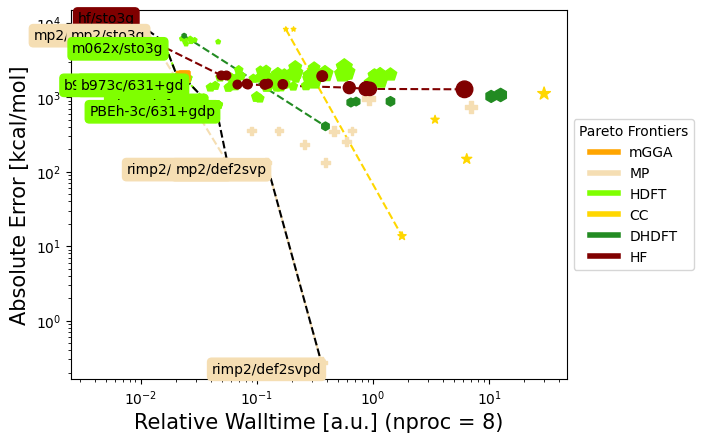

In [315]:
ax = plt.gca()

"""
plots methods in the same color and symbol. Determines and plots the pareto front.  
"""

for v in df[Dfcols.THEORYTYPE.value].unique():
    _df = df.filter(
            ~(pl.col(Dfcols.BASIS.value) == REF_BASIS) & (pl.col(Dfcols.LOT.value) == REF_LOT) #& (pl.col("software") != REF_SOFTWARE)
        )
    
    _df = df.filter((pl.col(Dfcols.THEORYTYPE.value) == v)) 

    """
    plots rel_walltime vs absolute error of each theory_type in the same color and same symbol
    """
    
    plt.scatter(_df[Dfcols.RELWALLTIME.value], _df[Dfcols.ABSERRORKCAL.value],
                s = (_df[Dfcols.NBASIS.value])/10,
                c = theory_type_style_dict[v][1],
                marker = theory_type_style_dict[v][0]
                )


    
    """
    checks if an entry is on the pareto front and plots the pareto front
    """
    _pf = _df.filter(
        is_pareto_efficient(
            _df[[Dfcols.ABSERRORKCAL.value, Dfcols.WALLTIME.value]].to_numpy())
        ).sort([Dfcols.RELWALLTIME.value, Dfcols.ABSERRORKCAL.value])

    plt.plot(_pf[Dfcols.RELWALLTIME.value],
            _pf[Dfcols.ABSERRORKCAL.value],
             zorder = -1,
             linestyle = main_pareto_line_style,
             c = theory_type_style_dict[v][1],
            )
    
values_to_compare = df.filter(
            (pl.col(Dfcols.BASIS.value) != REF_BASIS) | (pl.col(Dfcols.LOT.value) != REF_LOT) #& (pl.col("software") != REF_SOFTWARE)
        )

values_to_compare_pf = values_to_compare.filter(
    is_pareto_efficient(
       values_to_compare[[Dfcols.ABSERRORKCAL.value, Dfcols.WALLTIME.value]].to_numpy())     
    ).sort([Dfcols.RELWALLTIME.value, Dfcols.ABSERRORKCAL.value]) 

plt.plot(values_to_compare_pf[Dfcols.RELWALLTIME.value],
        values_to_compare_pf[Dfcols.ABSERRORKCAL.value],
        zorder = -1,
        linestyle = main_pareto_line_style,
        c = main_pareto_front_color,
        )

min_USEkcalmol = min(values_to_compare_pf[Dfcols.ABSERRORKCAL.value])

min_USEkcalmol_rel_walltime = values_to_compare_pf.filter(pl.col(Dfcols.ABSERRORKCAL.value) == min_USEkcalmol)[Dfcols.RELWALLTIME.value][0]


"""
Labels Method and basis set and shifts the labels for certain theory types
"""

print("LOT/Basis on pareto front:")
zipped_vals = zip(*values_to_compare_pf[[Dfcols.THEORYTYPE.value, Dfcols.RELWALLTIME.value, Dfcols.ABSERRORKCAL.value, Dfcols.BASIS.value, Dfcols.LOT.value, Dfcols.SOFTWARE.value]])
for theory, x, y, basis, level_of_theory, software in zipped_vals:
    shift_ = 0
    print(f"{level_of_theory}/{basis}, {software}")
    if theory == "HF":
        shift_ = 0.5    
    ax.text(x + shift_/100, y + shift_*10**4, f"{level_of_theory}/{basis}", 
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(boxstyle="round",
                   ec=theory_type_style_dict[theory][1],
                   fc=theory_type_style_dict[theory][1],
                     )
           )

"""
Config data for axes and their labels, legend and saving of png file.
"""

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(f"Relative Walltime [a.u.] (nproc = {nproc})", fontsize = FONTSIZE)
ax.set_ylabel("Absolute Error [kcal/mol]", fontsize = FONTSIZE)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Line2D([0], [0], color=theory_type_style_dict[v][1], lw=4, label=v) for v in df[Dfcols.THEORYTYPE.value].unique()]
ax.legend(handles=legend_elements, title="Pareto Frontiers", loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("test3.pdf", bbox_inches="tight")

Text(0, 0.5, 'Log Walltime [s] (nproc = 8)')

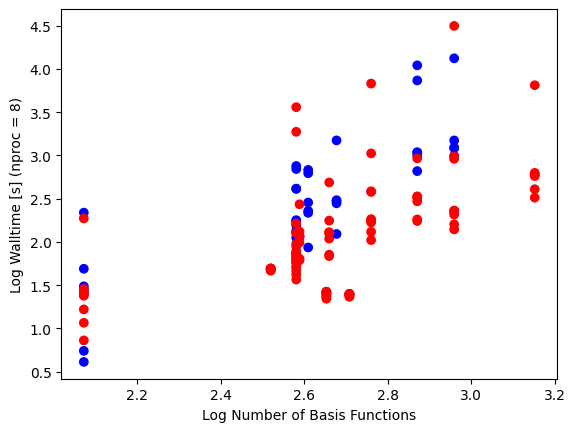

In [316]:
"""
plots nbasis vs walltime for different methods/basis sets in gaussian (blue) and orca (red)
"""

plt.scatter(np.log10(df[Dfcols.NBASIS.value]), np.log10(df[Dfcols.WALLTIME.value]), c = ["r" if softw == Software.ORCA.value else "b" for softw in df[Dfcols.SOFTWARE.value]])

#plt.scatter((df[Dfcols.NBASIS.value]), np.log(df[Dfcols.WALLTIME.value]), c = ["r" if softw == Software.ORCA.value else "b" for softw in df[Dfcols.SOFTWARE.value]])
#plt.xscale("log")
#plt.yscale("log")

plt.xlabel("Log Number of Basis Functions")
plt.ylabel(f"Log Walltime [s] (nproc = {nproc})")

slope: 1.8385487125878957, intercept: -5.555773904411111
slope: 1.3153499707965624, intercept: -3.6550347076853864


(0.0, 5.0)

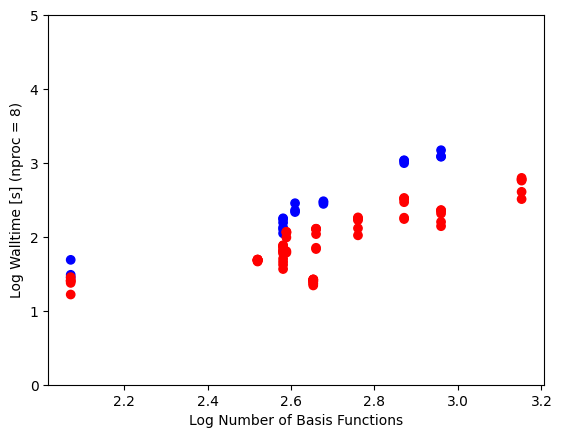

In [317]:
TYPE = "HDFT"

"""
plots nbasis vs walltime for a specific theory type in gaussian (blue)
"""


_ = df.filter(
    (pl.col(Dfcols.THEORYTYPE.value) == TYPE) & (pl.col(Dfcols.SOFTWARE.value) == Software.GAUSSIAN.value)
)

slope, intercept, r, p, se = linregress(np.log(_[Dfcols.NBASIS.value]), np.log(_[Dfcols.WALLTIME.value]))
print(f"slope: {slope}, intercept: {intercept}")

plt.scatter(np.log10(_[Dfcols.NBASIS.value]), np.log10(_[Dfcols.WALLTIME.value]), c = ["r" if x == Software.ORCA.value else "b" for x in _[Dfcols.SOFTWARE.value]]) 

plt.xlabel("Log Number of Basis Functions")
plt.ylabel("Log Walltime [s]")
plt.ylim(0, 5)

    



"""
plots nbasis vs walltime for a specific theory type in orca (red)
"""

_ = df.filter(
    (pl.col(Dfcols.THEORYTYPE.value) == TYPE) & (pl.col(Dfcols.SOFTWARE.value) == Software.ORCA.value)
)

slope, intercept, r, p, se = linregress(np.log(_[Dfcols.NBASIS.value]), np.log(_[Dfcols.WALLTIME.value]))
print(f"slope: {slope}, intercept: {intercept}")

plt.scatter(np.log10(_[Dfcols.NBASIS.value]), np.log10(_[Dfcols.WALLTIME.value]), c = ["r" if x == Software.ORCA.value else "b" for x in _[Dfcols.SOFTWARE.value]]) 

plt.xlabel("Log Number of Basis Functions")
plt.ylabel(f"Log Walltime [s] (nproc = {nproc})")
plt.ylim(0, 5)

In [318]:
"""
calculate and optimize exponential weight function using Nelder-Mead
"""

REFSOFTWARE = Software.ORCA.value #((for which software should the regression line be plotted?))
#REFSOFTWARE = Software.GAUSSIAN.value

_ = df.filter(
    (pl.col(Dfcols.THEORYTYPE.value) == TYPE) & (pl.col(Dfcols.SOFTWARE.value) == REFSOFTWARE)
)


def scaling(nbasis, x, a, c):
    return a * nbasis**x + c

def cost_function(args):
    nbasis = _[Dfcols.NBASIS.value]
    expected_walltime = _[Dfcols.WALLTIME.value]*nproc #*nproc so walltime is scaled for 1 proccessor 
    pred_walltime = [scaling(nb, *args) for nb in nbasis]
    cost = np.mean([(a - b)**2 for a, b in zip(expected_walltime, pred_walltime)])
    return cost

x0 = [1, 1, 0]
res = scipy.optimize.minimize(cost_function, x0, method='Nelder-Mead',
                    #bounds + [(2.5, 10), (0.1, 1), (-1000, 1000)]
                    )

res
    

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 212120.8869739823
             x: [ 1.566e+00  4.795e-02 -2.916e-03]
           nit: 153
          nfev: 275
 final_simplex: (array([[ 1.566e+00,  4.795e-02, -2.916e-03],
                       [ 1.566e+00,  4.795e-02, -2.916e-03],
                       [ 1.566e+00,  4.795e-02, -2.916e-03],
                       [ 1.566e+00,  4.796e-02, -2.916e-03]]), array([ 2.121e+05,  2.121e+05,  2.121e+05,  2.121e+05]))

Text(0, 0.5, 'Walltime (nproc = 1)')

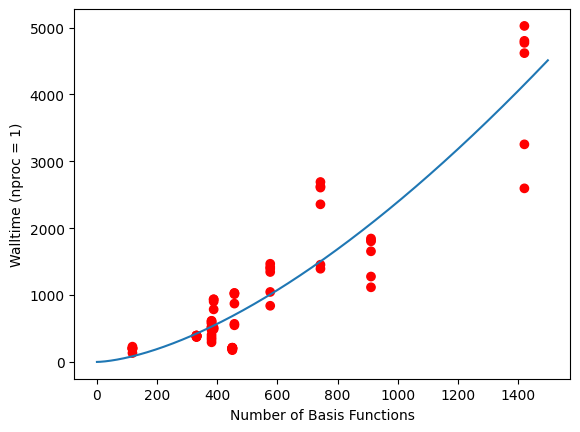

In [319]:
"""
plot regression line 
"""

plt.scatter(_[Dfcols.NBASIS.value], _[Dfcols.WALLTIME.value]*nproc, c = ["r" if software == Software.ORCA.value else "b" for software in _[Dfcols.SOFTWARE.value]])
xvalues = np.arange(0, 1500)
pred_walltimes = [scaling(nb, *res.x) for nb in xvalues]

plt.plot(xvalues, pred_walltimes)

plt.xlabel("Number of Basis Functions")
plt.ylabel("Walltime (nproc = 1)")

In [320]:
[*res.x]

[np.float64(1.5660588055991533),
 np.float64(0.047953025062839064),
 np.float64(-0.0029162730030339173)]

In [321]:
"""
calculate and optimize linear weight function using Nelder-Mead 
"""
def scaling(nbasis, m, c):
    return m*nbasis + c 

def cost_function(args):
    nbasis = _[Dfcols.NBASIS.value]
    expected_walltime = _[Dfcols.WALLTIME.value]*nproc #*nproc so walltime is scaled for 1 proccessor 
    pred_walltime = [scaling(nb, *args) for nb in nbasis]
    cost = np.mean([(a - b)**2 for a, b in zip(expected_walltime, pred_walltime)])
    return cost

x0 = [1, 0]
res = scipy.optimize.minimize(cost_function, x0, method='Nelder-Mead',
                    #bounds + [(2.5, 10), (0.1, 1), (-1000, 1000)]
                    )

res
    

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 240085.4261257047
             x: [ 3.192e+00 -6.784e+02]
           nit: 110
          nfev: 214
 final_simplex: (array([[ 3.192e+00, -6.784e+02],
                       [ 3.192e+00, -6.784e+02],
                       [ 3.192e+00, -6.784e+02]]), array([ 2.401e+05,  2.401e+05,  2.401e+05]))

Text(0, 0.5, 'Walltime (nproc = 1)')

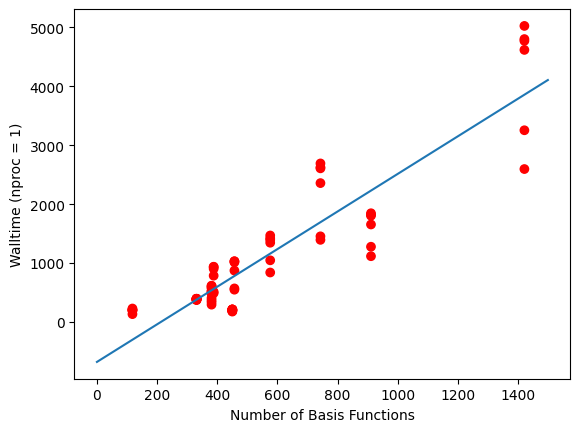

In [322]:
"""
plot regression line 
"""

plt.scatter(_[Dfcols.NBASIS.value], _[Dfcols.WALLTIME.value]*nproc, c = ["r" if software == Software.ORCA.value else "b" for software in _[Dfcols.SOFTWARE.value]])
xvalues = np.arange(0, 1500)
pred_walltimes = [scaling(nb, *res.x) for nb in xvalues]

plt.plot(xvalues, pred_walltimes)

plt.xlabel("Number of Basis Functions")
plt.ylabel("Walltime (nproc = 1)")

In [323]:
[*res.x]

[np.float64(3.192329412809495), np.float64(-678.3556386375963)]